In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mdutils.mdutils import MdUtils
import matplotlib.pyplot as plt
import matplotlib as mpl


# Load the data
duration_orig = gpd.read_file('../data/derived_data/workflow/flats_duration_current.gpkg')
duration_iso = gpd.read_file('../data/derived_data/workflow/flats_duration_clustering_iso.gpkg')
duration_ors = gpd.read_file('../data/derived_data/workflow/flats_duration_clustering_ors.gpkg')
duratition__otp= gpd.read_file('../data/derived_data/workflow/flats_duration_opt.gpkg')


In [ ]:
# Calculate population weighted duration for each dataset
orig_weighted = (duration_orig['duration'] * duration_orig['est_pop']).sum() / duration_orig['est_pop'].sum()
iso_weighted = (duration_iso['duration'] * duration_iso['est_pop']).sum() / duration_iso['est_pop'].sum()
ors_weighted = (duration_ors['duration'] * duration_ors['est_pop']).sum() / duration_ors['est_pop'].sum()
opt_weighted = (duratition__otp['duration'] * duratition__otp['est_pop']).sum() / duratition__otp['est_pop'].sum()

# Calculate population outside 10-minute range for each dataset
orig_outside = duration_orig[duration_orig['duration'] > 10]['est_pop'].sum()
iso_outside = duration_iso[duration_iso['duration'] > 10]['est_pop'].sum()
ors_outside = duration_ors[duration_ors['duration'] > 10]['est_pop'].sum()
opt_outside = duratition__otp[duratition__otp['duration'] > 10]['est_pop'].sum()

# Calculate total population
total_pop = duration_orig['est_pop'].sum()

# Calculate coverage percentage for each dataset
orig_coverage = ((total_pop - orig_outside) / total_pop) * 100
iso_coverage = ((total_pop - iso_outside) / total_pop) * 100
ors_coverage = ((total_pop - ors_outside) / total_pop) * 100
opt_coverage = ((total_pop - opt_outside) / total_pop) * 100

# Function to format time in min:sec
def format_time(minutes):
    mins = int(minutes)
    secs = int((minutes - mins) * 60)
    return f"{mins}:{secs:02d}"

# Create a DataFrame with the comparison results
comparison_df = pd.DataFrame({
    'Method': ['Current Situation', 'Isochrones+Clustering', 'Routing+Clustering', "Linear Optimisation"],
    'Population Outside 10min': [orig_outside, iso_outside, ors_outside, opt_outside],
    'Coverage (%)': [orig_coverage, iso_coverage, ors_coverage, opt_coverage],
    'walking_time': [format_time(orig_weighted), format_time(iso_weighted), 
                                   format_time(ors_weighted), format_time(opt_weighted)],
    'Number of additional RCPs': [0, 10, 12, 10]
})

comparison_df.sort_values(by='walking_time', inplace=True, ascending=False)


: 

In [38]:
comparison_df

,Method,Population Outside 10min,Coverage (%),walking_time,Number of additional RCPs
0,Current Situation,9329.364029,97.908288,4:06,0
2,Routing+Clustering,6062.397480,98.640766,4:01,12
1,Isochrones+Clustering,4126.244137,99.074866,3:55,10
3,Linear Optimisation,3575.588022,99.198327,3:52,10


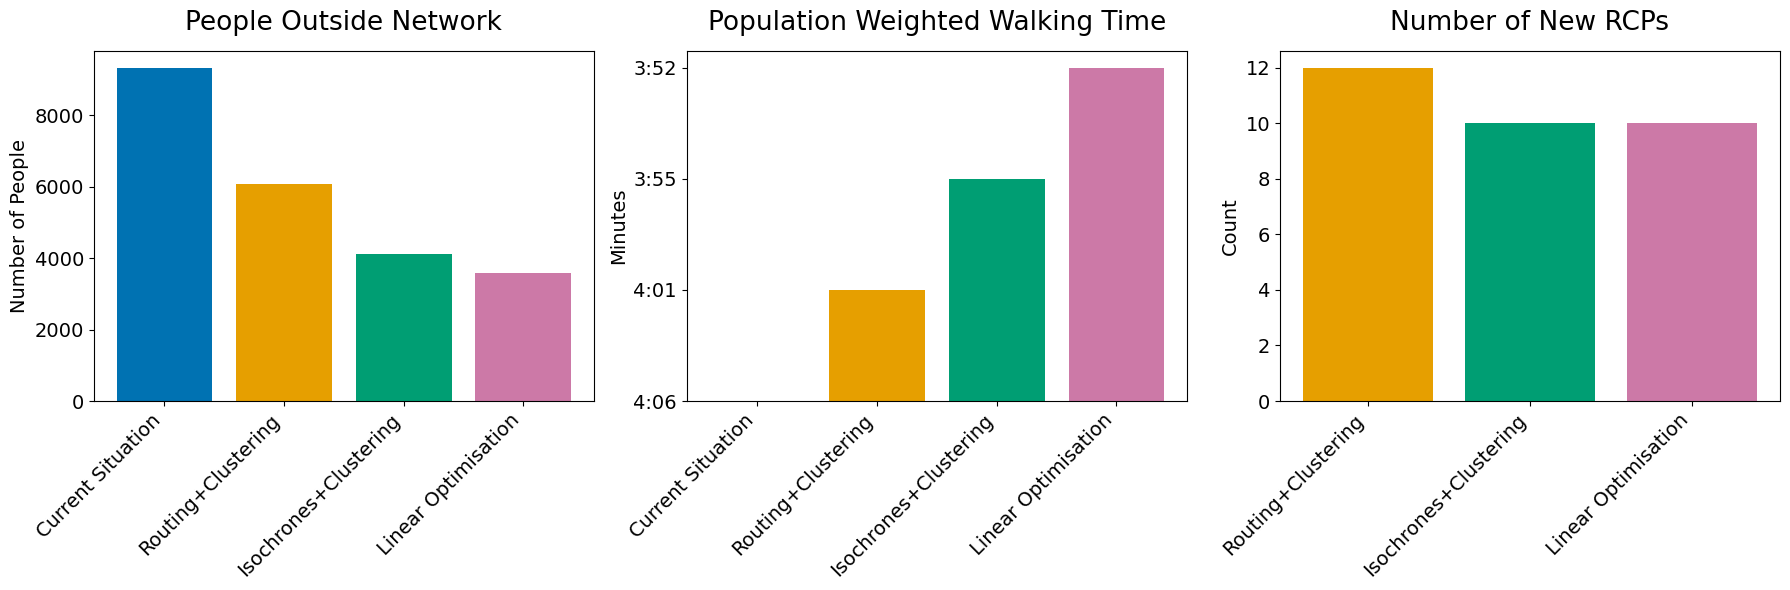

: 

In [ ]:

# Set bright theme color parameters
background_color = 'white'
text_color = 'black'

# Colorblind-friendly palette (Okabe-Ito) - for bright background
colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']  # Blue, Orange, Green, Purple

# Create figure with bright theme
plt.figure(figsize=(18, 6), facecolor=background_color)

# Plot 1: People Outside Network
plt.subplot(1, 3, 1)
bars1 = plt.bar(comparison_df['Method'], comparison_df['Population Outside 10min'], color=colors)
plt.title('People Outside Network', fontsize=TITLE_SIZE, color=text_color, pad=15)
plt.ylabel('Number of People', fontsize=LABEL_SIZE, color=text_color)
plt.xticks(rotation=45, fontsize=TICK_SIZE, color=text_color, ha='right')
plt.gca().set_facecolor(background_color)
plt.gca().tick_params(colors=text_color)
for spine in plt.gca().spines.values():
    spine.set_color(text_color)

# Plot 2: Walking Time
plt.subplot(1, 3, 2)
bars2 = plt.bar(comparison_df['Method'], comparison_df['walking_time'], color=colors)
plt.title('Population Weighted Walking Time', fontsize=TITLE_SIZE, color=text_color, pad=15)
plt.ylabel('Minutes', fontsize=LABEL_SIZE, color=text_color)
plt.xticks(rotation=45, fontsize=TICK_SIZE, color=text_color, ha='right')
plt.gca().set_facecolor(background_color)
plt.gca().tick_params(colors=text_color)
for spine in plt.gca().spines.values():
    spine.set_color(text_color)

# Plot 3: Number of New RCPs
plt.subplot(1, 3, 3)
bars3 = plt.bar(comparison_df['Method'][1:], comparison_df['Number of additional RCPs'][1:], color=colors[1:])
plt.title('Number of New RCPs', fontsize=TITLE_SIZE, color=text_color, pad=15)
plt.ylabel('Count', fontsize=LABEL_SIZE, color=text_color)
plt.xticks(rotation=45, fontsize=TICK_SIZE, color=text_color, ha='right')
plt.gca().set_facecolor(background_color)
plt.gca().tick_params(colors=text_color)
for spine in plt.gca().spines.values():
    spine.set_color(text_color)

plt.tight_layout()

# Save the combined figure
plt.savefig('../data/plots/comparison_metrics.png', dpi=400, bbox_inches='tight', facecolor=background_color)
plt.show()

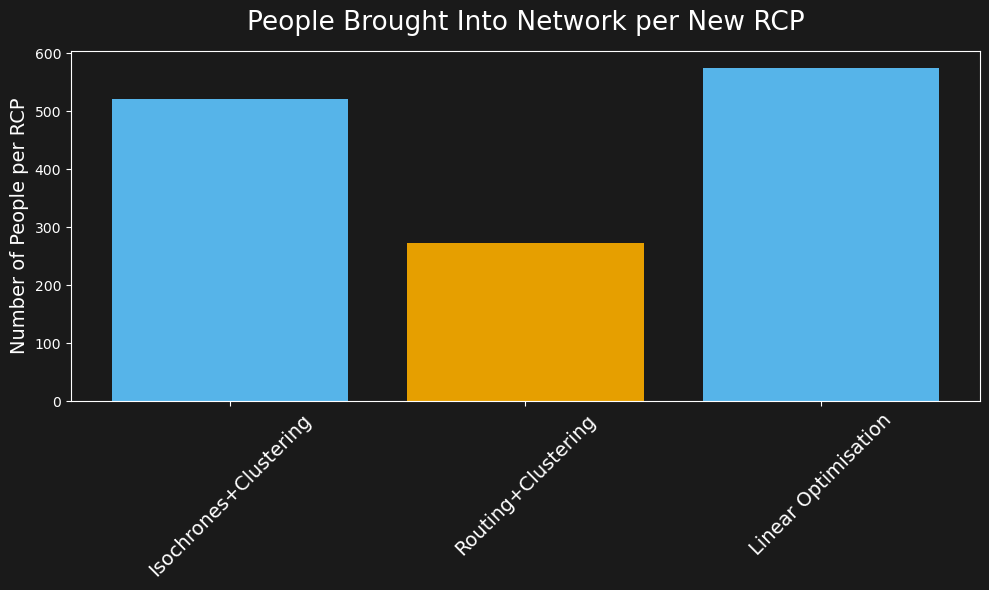

In [24]:
# Calculate people brought in by comparing to current situation
people_brought_in = comparison_df.loc[0, 'Population Outside 10min'] - comparison_df.loc[1:, 'Population Outside 10min']
new_rcps = comparison_df.loc[1:, 'Number of additional RCPs']

# Calculate people per RCP
people_per_rcp = people_brought_in / new_rcps

# Create figure with dark theme
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')

# Plot the data
plt.bar(comparison_df['Method'][1:], people_per_rcp, color=colors[0:2])

# Customize the plot
plt.title('People Brought Into Network per New RCP', fontsize=TITLE_SIZE, color='white', pad=15)
plt.ylabel('Number of People per RCP', fontsize=LABEL_SIZE, color='white')
plt.xticks(rotation=45, fontsize=TICK_SIZE, color='white')
plt.gca().set_facecolor('#1a1a1a')
plt.gca().tick_params(colors='white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.tight_layout()

# Save and show the plot
plt.savefig('../data/plots/people_brought_in_per_rcp.png', dpi=400, bbox_inches='tight', facecolor='#1a1a1a')
plt.show()


In [ ]:

# Add a row with Linear Optimisation data
new_row = pd.DataFrame({
    'Method': ['Linear Optimisation'],
    'Population Outside 10min': ['?'],
    'Coverage (%)': ['?'], 
    'Average Walking Time (min)': ['?'],
    'Number of additional RCPs': ['?']
})

comparison_df_rounded = pd.concat([comparison_df, new_row], ignore_index=True)

# Create markdown file
mdFile = MdUtils(file_name='../data/plots/comparison_table.md')

# Add title
mdFile.write("\n## Comparison Table\n")

# Create table header 
headers = comparison_df_rounded.columns.tolist()
table = [headers]

# Add rows
for _, row in comparison_df_rounded.iterrows():
    table.append([str(val) for val in row.values])

# Create table with mdutils
mdFile.new_table(columns=len(headers), rows=len(table), text=sum(table, []))

# Create file
mdFile.create_md_file()